In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import cloudpickle

In [4]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.io import write
from pwtools import io

# Functions

In [5]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'calculation': input_dict["calculation"],
            'occupations': 'smearing',
            'degauss': input_dict["smearing"],
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [6]:
def collect_output(working_directory="."):
    filename = os.path.join(working_directory, 'output.pwo')
    try:
        return {"structure": io.read_pw_md(filename)[-1].get_ase_atoms()}
    except TypeError:
        out = io.read_pw_scf(filename)
        return {
            "energy": out.etot,
            "volume": out.volume,
        }

In [7]:
def workflow(project, structure): 
    # Structure optimization 
    job_qe_minimize = pr.create.job.QEJob(job_name="qe_relax")
    job_qe_minimize.input["calculation"] = "vc-relax"
    job_qe_minimize.input.structure = structure
    job_qe_minimize.run()
    structure_opt = job_qe_minimize.output.structure

    # Energy Volume Curve 
    energy_lst, volume_lst = [], []
    for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
        structure_strain = structure_opt.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain**(1/3), 
            scale_atoms=True
        )
        job_strain = pr.create.job.QEJob(
            job_name="job_strain_" + str(i)
        )
        job_strain.input.structure = structure_strain
        job_strain.run(delete_existing_job=True)
        energy_lst.append(job_strain.output.energy)
        volume_lst.append(job_strain.output.volume)
    
    return {"volume": volume_lst, "energy": energy_lst}

# Setup

In [8]:
from pyiron_base import Project

In [9]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

In [10]:
pr.create_job_class(
    class_name="QEJob",
    write_input_funct=write_input,
    collect_output_funct=collect_output,
    default_input_dict={  # Default Parameter 
        "structure": None, 
        "pseudopotentials": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, 
        "kpts": (3, 3, 3),
        "calculation": "scf",
        "smearing": 0.02,
    },
    executable_str="mpirun -np 1 pw.x -in input.pwi > output.pwo",
)

# Workflow

In [11]:
job_workflow = pr.wrap_python_function(workflow)
job_workflow.input.project = pr
job_workflow.input.structure = bulk('Al', a=4.05, cubic=True)
job_workflow.run()

The job workflow4f4e485d84b2077fb84bc6a8d40cf7c0 was saved and received the ID: 82
The job qe_relax was saved and received the ID: 83
The job job_strain_0 was saved and received the ID: 84
The job job_strain_1 was saved and received the ID: 85
The job job_strain_2 was saved and received the ID: 86
The job job_strain_3 was saved and received the ID: 87
The job job_strain_4 was saved and received the ID: 88


# Result

Text(0, 0.5, 'Energy')

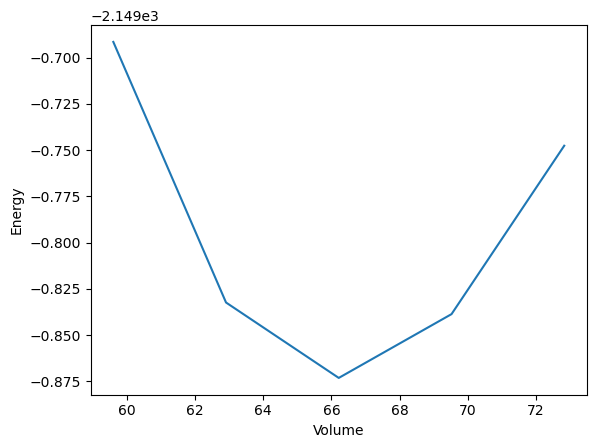

In [12]:
plt.plot(job_workflow.output.result["volume"], job_workflow.output.result["energy"])
plt.xlabel("Volume")
plt.ylabel("Energy")

# Summary

In [13]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,82,finished,None,workflow4f4e485d84b2077fb84bc6a8d40cf7c0,/workflow4f4e485d84b2077fb84bc6a8d40cf7c0,/home/jovyan/,test/,2024-04-02 21:45:28.248048,NaT,NaN,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,PythonFunctionContainerJob,0.4,None,None
1,83,finished,None,qe_relax,/qe_relax,/home/jovyan/,test/,2024-04-02 21:45:28.421375,2024-04-02 21:47:27.565301,119.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
2,84,finished,None,job_strain_0,/job_strain_0,/home/jovyan/,test/,2024-04-02 21:47:27.737503,2024-04-02 21:47:52.733433,24.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
3,85,finished,None,job_strain_1,/job_strain_1,/home/jovyan/,test/,2024-04-02 21:47:52.907486,2024-04-02 21:48:17.518090,24.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
4,86,finished,None,job_strain_2,/job_strain_2,/home/jovyan/,test/,2024-04-02 21:48:17.709471,2024-04-02 21:48:42.796625,25.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
5,87,finished,None,job_strain_3,/job_strain_3,/home/jovyan/,test/,2024-04-02 21:48:42.945954,2024-04-02 21:49:16.639389,33.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
6,88,finished,None,job_strain_4,/job_strain_4,/home/jovyan/,test/,2024-04-02 21:49:16.791634,2024-04-02 21:49:47.803456,31.0,pyiron@jupyter-jan-2djanssen-2dimsi-2dtutorial-2d1b0qqaa4#1,ExecutableContainerJob,0.4,None,None
